<a href="https://colab.research.google.com/github/mudita11/Covid-visual/blob/main/CWT_CaseStudy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dateutil.parser import parse
from collections import Counter
import nltk
import string
import re
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, roc_curve, pairwise_distances, roc_auc_score, precision_score, recall_score, precision_recall_curve, mean_squared_error
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.options.display.max_rows = 50
pd.options.display.max_columns = 50

In [2]:
def count_unique(col, txt, sort_index):
    unique_restaurant = np.unique(col, return_counts = True)
    a = unique_restaurant[0]
    b = unique_restaurant[1]
    unique_restaurant_all = list(zip(a, b))
    print('Number of unique {} {}'.format(txt, len(unique_restaurant_all)))
    sorted_unique_restaurant_all = sorted(unique_restaurant_all, key=lambda t: t[sort_index], reverse=True)
    return a, b, sorted_unique_restaurant_all

In [3]:
df = pd.read_csv('London_reviews.csv', header=None)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (0,1,3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,NaN,parse_count,restaurant_name,rating_review,sample,review_id,title_review,review_preview,review_full,date,city,url_restaurant,author_id
1,0.0,1,Cocotte_Notting_Hill,5.0,Positive,review_771556136,JUST PERFECT,I was away for couple of months and I am so h...,I was away for couple of months and I am so ha...,"September 23, 2020",London_England,https://www.tripadvisor.com/Restaurant_Review-...,UID_0
2,1.0,2,Cocotte_Notting_Hill,5.0,Positive,review_771555883,"Quality food, Food travels well, Excellent cus...",I recently ordered over the phone from Cocotte...,I recently ordered over the phone from Cocotte...,"September 23, 2020",London_England,https://www.tripadvisor.com/Restaurant_Review-...,UID_1
3,2.0,3,Cocotte_Notting_Hill,5.0,Positive,review_770716943,Came here because we missed,Came here because we missed our table at Farma...,Came here because we missed our table at Farma...,"September 17, 2020",London_England,https://www.tripadvisor.com/Restaurant_Review-...,UID_2
4,3.0,4,Cocotte_Notting_Hill,5.0,Positive,review_770027676,Great service,My first time in cocotte and was amazed by how...,My first time in cocotte and was amazed by how...,"September 12, 2020",London_England,https://www.tripadvisor.com/Restaurant_Review-...,UID_3


In [4]:
arr = df.to_numpy()

Shape and columns

In [6]:
print('(Number of rows, number of columns) - {}'.format(np.shape(arr)))
arr[0][0]='Index'
all_columns = {item:idx for idx, item in enumerate(arr[0])}
all_columns
arr = arr[1:]

(Number of rows, number of columns) - (996568, 13)


{'Index': 0,
 'parse_count': 1,
 'restaurant_name': 2,
 'rating_review': 3,
 'sample': 4,
 'review_id': 5,
 'title_review': 6,
 'review_preview': 7,
 'review_full': 8,
 'date': 9,
 'city': 10,
 'url_restaurant': 11,
 'author_id': 12}

Convert column type
restaurant_name: str
title_review: str
review_full: str
city: str

In [7]:
arr[:, all_columns['restaurant_name']] = arr[:, all_columns['restaurant_name']].astype('str')
arr[:, all_columns['title_review']] = arr[:, all_columns['title_review']].astype('str')
arr[:, all_columns['city']] = arr[:, all_columns['city']].astype('str')
arr[:, all_columns['author_id']] = arr[:, all_columns['author_id']].astype('str')

Review 'rating_review' column and remove rows with incorrect values

In [7]:
#rating_review column
arr[:, all_columns['rating_review']]

array(['5.0', '5.0', '5.0', ..., 5.0, 5.0, 3.0], dtype=object)

In [8]:
strings = ['', ' ', 'London_England']
rows_to_delete = [i for i, item in enumerate(arr[:, all_columns['rating_review']]) if item in strings]
print('Ratings as string {}'.format(rows_to_delete))
arr = np.delete(arr, rows_to_delete, 0)

Ratings as string [196134, 412023, 592755, 602263, 604122, 662621]


Change type, rating_review: int

In [9]:
arr[:, all_columns['rating_review']] = arr[:, all_columns['rating_review']].astype('float').astype('int')

Remove rows based rating_review incorrect values

In [10]:
rows_to_delete = [(np.where(arr[:, all_columns['rating_review']]<0) or (arr[:, all_columns['rating_review']]>5))]
print('Ratings with incorrect score {}'.format(rows_to_delete))
arr = np.delete(arr, rows_to_delete, 0)

Ratings with incorrect score [(array([412019, 412020, 412021, 592748, 592749, 592750, 592751, 592752,
       602259]),)]


Counts of unique rating_review

Number of unique ratings 5


[(5, 584698), (4, 246994), (3, 87052), (2, 41877), (1, 35931)]

<BarContainer object of 5 artists>

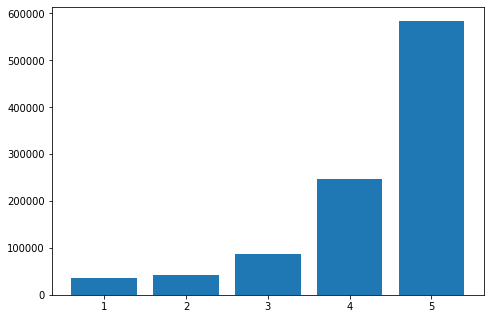

In [11]:
#1-3: Negative, 4-5: Positive
a, b, sorted_unique_rating = count_unique(arr[:, all_columns['rating_review']], 'ratings', 1)
sorted_unique_rating
### Bar plot for rating_review count
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(a, b)
plt.show()

Count unique restaurants

In [12]:
sorted_unique_rest, a, b = count_unique(arr[:, all_columns['restaurant_name']], 'restaurant', 1)
sorted_unique_rest

Number of unique restaurant 1827


array(['100_Wardour_St', '108_Brasserie', '10_Greek_Street', ..., 'Zoilo',
       'Zonzo_Restaurant', 'Zuma_London'], dtype=object)

Best and worst restaurants based on rating_review

In [13]:
pos_mean = [np.mean(arr[arr[:, all_columns['restaurant_name']]==i, all_columns['rating_review']], axis=0) for i in sorted_unique_rest]
max_idx = pos_mean.index(max(pos_mean))
print(f'{sorted_unique_rest[max_idx]} restaurant has maximum average rating of {pos_mean[max_idx]}')
min_idx = pos_mean.index(min(pos_mean))
print(f'{sorted_unique_rest[min_idx]} restaurant has minimum average rating of {pos_mean[min_idx]}')

Dera restaurant has maximum average rating of 5.0
London_Secret_Garden restaurant has minimum average rating of 3.2941176470588234


Number of unique reviewers

In [14]:
a, b, sorted_unique_author = count_unique(arr[:, all_columns['author_id']], 'user', 1) #(restaurant_name:count)

Number of unique user 502227


 Number of reviews per user

In [ ]:
author_freq_count = Counter(arr[:, all_columns['author_id']]).most_common() 
print(len(author_freq_count))
review_freq, author_count = list(zip(*(author_freq_count)))
fig = plt.figure()
ax = fig.add_axes([1,1,1,1])
ax.bar(review_freq, author_count)
plt.show()

502227


KeyboardInterrupt: ignored

In [ ]:
sorted(author_freq_count, key=lambda x:x[1], reverse=True)[:20]

Number of positive vs negative reviews

In [ ]:
a, b, sorted_unique_sample = count_unique(arr[:, all_columns['sample']], 'sentiment', 1)
sorted_unique_sample
### Bar plot for sample count
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(a, b)
plt.show()

Remove nan reviews

In [11]:
nan_review = [idx for idx, item in enumerate(arr[:, all_columns['review_full']]) if isinstance(item, float)]
print('Row index with nan reviews {}'.format(nan_review))
arr = np.delete(arr, nan_review, 0)

Row index with nan reviews [196133, 412018, 592744, 602250, 604108, 662606]


In [12]:
for item in arr[:,2]:
    if isinstance(item, float):
      print(item)

Change type, date: str and datetime format

In [ ]:
arr[:, all_columns['date']] = arr[:, all_columns['date']].astype('str')
arr[:, all_columns['date']][:10]
wo_nan_date = [item for item in arr[:, all_columns['date']] if item != 'nan']
min(wo_nan_date)
max(wo_nan_date)

Count unique cities

In [ ]:
unique_city = np.unique(arr[:, all_columns['city']], return_counts = True)
unique_city_all = list(zip(unique_city[0],unique_city[1]))
print('Number of unique cities {}'.format(len(unique_city_all)))
sorted_unique_city_all = sorted(unique_city_all, key=lambda t: t[1], reverse=True)
sorted_unique_city_all

Drop unnecessary columns

In [13]:
drop_col = ['Index', 'parse_count', 'restaurant_name', 'sample', 'review_id', 'review_preview', 'date', 'city',  'url_restaurant','author_id'] 
col_to_delete = [all_columns[item] for item in drop_col]
arr_clean = np.delete(arr, col_to_delete, 1)

In [14]:
merge_txt = arr_clean[:,1]+' '+arr_clean[:,2]
merge_txt[0]

'JUST PERFECT I was away for couple of months and I am so happy to be back for my regular cocotte meal, after collecting from the restaurant everything was as great and perfect than eating in. Juicy chicken, fresh side, amazing mash potato.What a great dinner at home again thanks to COCOTTE.'

Check common reviews

In [15]:
print(len(arr_clean[:,2]) - len(set(arr_clean[:,2])))

293


Pre-process text

In [40]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    #elif tag.startswith('N'):
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def process(sentence):
    # Remove special charaters
    output = re.findall('[\w]+', sentence.lower())
    # Remove digits
    output = [re.sub(r'\d+', '', item) for item in output]
    # Remove urls
    output = [re.sub(r'http\S+', '', item) for item in output]
    #work level tokenise
    #word_list = nltk.word_tokenize(output)
    #pos tag
    output = nltk.pos_tag(output)
    # lemmatize
    tokens = [lemmatizer.lemmatize(item[0], get_wordnet_pos(item[1])) for item in output if item[0] not in stop]
    # if using TfidfVectorizer or CountVectorizer, as they expect sentence and not tokens. They tokenise themselves.
    tokens = (' ').join(tokens)
    return tokens

In [ ]:
#Initialise lemmatizer
lemmatizer = WordNetLemmatizer()
# stop words
stop = set(stopwords.words('english') + list(string.punctuation))
stop.add('')
processed_reviews = [process(sent) for sent in merge_txt]
processed_reviews[0]

Identify restaurant cuisine

In [95]:
cuisine_list = ['chinese', 'italian', 'indian', 'japanese', 'pakistani', 'indonesian', 'german', 'british', 'irish', 'mediterranean', 'dutch', 'french',
                'brazilian', 'jamaican', 'korean', 'american', 'malaysian', 'singaporean', 'afghan', 'bangladesh', 'nepalese', 'sri lankan']
d1 = {item:[] for item in cuisine_list}
for idx, item in enumerate(processed_reviews):
    for token in item.split():
        if token.lower() in d1:
            d1[token].append(idx)

for k, v in sorted(d1.items(), key=lambda x:len(x[1]), reverse=True):
    print(k, len(v))

italian 69600
indian 60814
french 27766
british 12856
japanese 10028
american 9210
chinese 8928
mediterranean 3181
korean 2647
german 2578
malaysian 1557
irish 1532
brazilian 1313
nepalese 1124
indonesian 568
pakistani 424
singaporean 208
dutch 166
jamaican 120
bangladesh 102
afghan 30
sri lankan 0


Vector representation

In [54]:
vectorizer = TfidfVectorizer()#CountVectorizer()
X = vectorizer.fit_transform(processed_reviews)
Y = arr_clean[:,0]
print(np.shape(X))
print(np.shape(Y))

(996546, 190141)
(996546,)


Train-Test split

In [55]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)
Y_train=Y_train.astype('int')
Y_test=Y_test.astype('int')
print(np.shape(X_train), np.shape(X_test), np.shape(Y_train), np.shape(Y_test))

(747409, 190141) (249137, 190141) (747409,) (249137,)


Random Forest Classifier

In [79]:
model = RandomForestClassifier(max_depth=10, class_weight='balanced_subsample')
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)
label_encoder = LabelEncoder()
Y_train_enc = label_encoder.fit_transform(Y_train)
scores = cross_val_score(model, X_train, Y_train_enc, scoring='accuracy', cv=cv)
print(f'Mean Accuracy Score (Train set): {np.mean(scores)}')

Mean Accuracy Score (Train set): 0.6335540555524048


In [57]:
all_rows = len(arr_clean)
class_weight = {item[0]:1-(item[1]/all_rows) for item in sorted_unique_rating}
rfc = RandomForestClassifier(max_depth=2, class_weight=class_weight)
rfc.fit(X_train, Y_train)
Y_predict_train = rfc.predict(X_train)
Y_predict_test = rfc.predict(X_test)
print(f'Accuracy Score (Train set): {accuracy_score(Y_train, Y_predict_train)}')
print(f'Accuracy Score (Test set): {accuracy_score(Y_test, Y_predict_test)}')

RandomForestClassifier(class_weight={1: 0.9639444641792753,
                                     2: 0.9579778555129417,
                                     3: 0.9126462802519903,
                                     4: 0.7521499258438646,
                                     5: 0.41327545341609917},
                       max_depth=2)

Accuracy Score (Train set): 0.5865597015824
Accuracy Score (Test set): 0.5872070386975841


In [58]:
lr = LogisticRegression()
lr.fit(X_train, Y_train)
Y_predict_train = lr.predict(X_train)
Y_predict_test = lr.predict(X_test)
print(f'Accuracy Score (Train set): {accuracy_score(Y_train, Y_predict_train)}')
print(f'Accuracy Score (Test set): {accuracy_score(Y_test, Y_predict_test)}')

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

Accuracy Score (Train set): 0.7482650061746647
Accuracy Score (Test set): 0.7372810943376535


In [56]:
all_rows = len(arr_clean)
class_weight = {item[0]:1-(item[1]/all_rows) for item in sorted_unique_rating}
lr = LogisticRegression(class_weight=class_weight)
lr.fit(X_train, Y_train)
Y_predict_train = lr.predict(X_train)
Y_predict_test = lr.predict(X_test)
print(f'Accuracy Score (Train set): {accuracy_score(Y_train, Y_predict_train)}')
print(f'Accuracy Score (Test set): {accuracy_score(Y_test, Y_predict_test)}')

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(class_weight={1: 0.9639444641792753, 2: 0.9579778555129417,
                                 3: 0.9126462802519903, 4: 0.7521499258438646,
                                 5: 0.41327545341609917})

Accuracy Score (Train set): 0.7365819785418694
Accuracy Score (Test set): 0.7248301135519815


In [59]:
lin = LinearRegression()
lin.fit(X_train, Y_train)
Y_predict_train = lin.predict(X_train)
Y_predict_test = lin.predict(X_test)
print(f'MSE (Train set): {mean_squared_error(Y_train, Y_predict_train)}')
print(f'MSE (Test set): {mean_squared_error(Y_test, Y_predict_test)}')

KeyboardInterrupt: ignored

In [ ]:
rfr = RandomForestRegressor(max_depth=2, random_state=0)
rfr.fit(X_train, Y_train)
Y_predict_train = rfr.predict(X_train)
Y_predict_test = rfr.predict(X_test)
print(f'Accuracy Score (Train set): {mean_squared_error(Y_train, Y_predict_train)}')
print(f'Accuracy Score (Test set): {mean_squared_error(Y_test, Y_predict_test)}')

In [ ]:
#data = np.transpose(np.vstack((arr[:,0], processed_reviews)))
#np.shape(data)
#data[0]

In [18]:
#nltk.download('punkt')
#nltk.download('wordnet')
#nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True